In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [2]:
xmain = np.load('fiberData120x.npy')
ymain = np.load('fiberData120y.npy')
ysub = np.load('completion.npy')
xtest,xval,ytest,yval = train_test_split(xmain,ymain,test_size=0.2,random_state=1)
xtest2,xval2,ytest2,yval2 = train_test_split(xmain,ysub,test_size=0.2,random_state=1)

In [3]:
class fslice:
    def __init__():
        pass
    def window1(din):
        d = din
        return d
    def window3(din):
        d = din
        insert = d[:,0:1,:]*0
        #insert = tf.constant(np.zeros((1,1,2)),tf.float32)
        d = tf.concat([insert, d, insert],axis=-2)
        # 切分数据集,分别是开头，中间，末尾，长度保持不变
        d1 = d[:,:-2,:]
        d2 = d[:,1:-1,:]
        d3 = d[:,2:,:]
        # 拼接成长度6的数对，以代表输入坐标
        dout = tf.concat([d1,d2,d3],axis=-1)
        return dout
    def window3r(din):
        d = din
        insert1 = d[:,0:1,:]
        insert2 = d[:,-2:-1,:]
        d = tf.concat([insert1,d,insert2],axis=-2)
        d1 = d[:,:-2,:]
        d2 = d[:,1:-1,:]
        d3 = d[:,2:,:]
        dout = tf.concat([d1,d2,d3],axis=-1)
        return dout
    def window5(din):
        d = din
        # 对开头和末尾补零，返回b+4
        insert = d[:,0:2,:]*0
        #insert = tf.constant(np.zeros((1,2,2)),tf.float32)
        d = tf.concat([insert, d, insert],axis=-2)
        d1 = d[:,:-4,:]
        d2 = d[:,1:-3,:]
        d3 = d[:,2:-2,:]
        d4 = d[:,3:-1,:]
        d5 = d[:,4:,:]
        dout = tf.concat([d1,d2,d3,d4,d5],axis=-1)
        return dout
    def window7(din):
        d = din
        insert = d[:,0:3,:]*0
        #insert = tf.constant(np.zeros((1,3,2)),tf.float32)
        d = tf.concat([insert, d, insert],axis=-2)
        d1 = d[:,:-6,:]
        d2 = d[:,1:-5,:]
        d3 = d[:,2:-4,:]
        d4 = d[:,3:-3,:]
        d5 = d[:,4:-2,:]
        d6 = d[:,5:-1,:]
        d7 = d[:,6:,:]
        dout = tf.concat([d1,d2,d3,d4,d5,d6,d7],axis=-1)
        return dout
    def window9(din):
        d = din
        insert = d[:,0:4,0]*0
        d = tf.concat([insert, d, insert],axis=-2)
        d1 = d[:,:-8,:]
        d2 = d[:,1:-7,:]
        d3 = d[:,2:-6,:]
        d4 = d[:,3:-5,:]
        d5 = d[:,4:-4,:]
        d6 = d[:,5:-3,:]
        d7 = d[:,6:-2,:]
        d8 = d[:,7:-1,:]
        d9 = d[:,8:,:]
        dout = tf.concat([d1,d2,d3,d4,d5,d6,d7,d8,d9],axis=-1)
        return dout
    def expand2to3(tensorin):
        if len(tensorin.shape) == 2:
            tensor = tensorin
            expand = tf.expand_dims(tensor, axis=0)
            return expand
        else:
            return tensorin

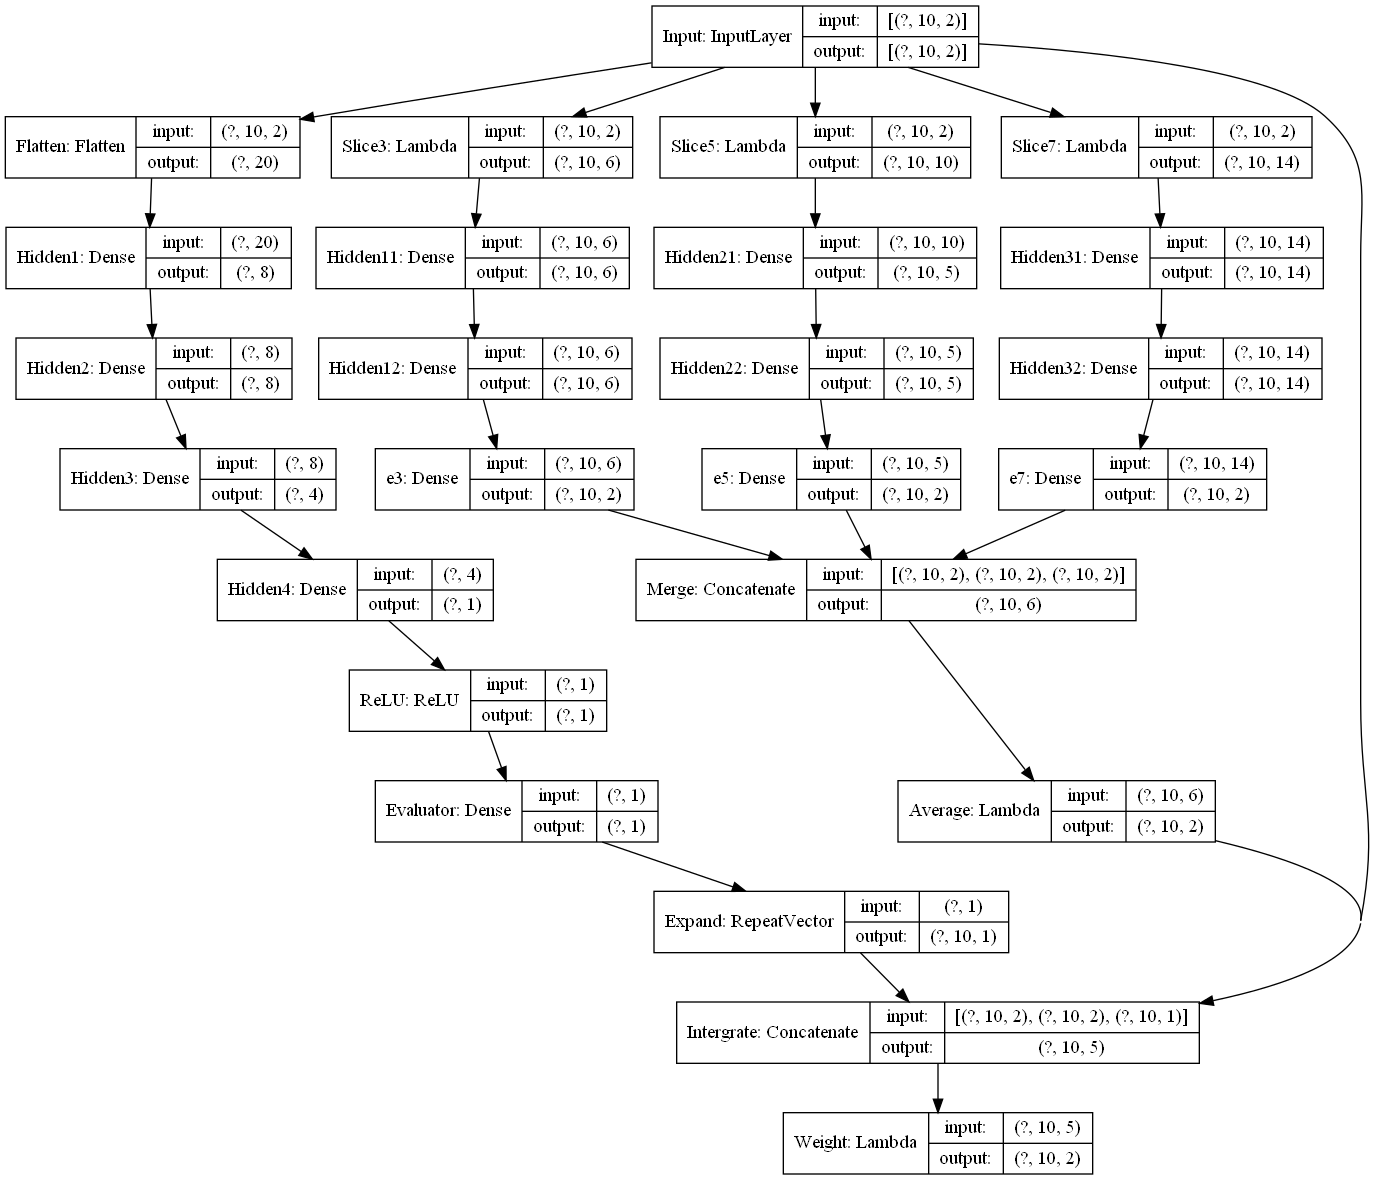

In [4]:
# input
inputs = tf.keras.layers.Input(shape=(10,2),name='Input')
# slice = 3
window3 = tf.keras.layers.Lambda(fslice.window3,input_shape=(10,2),output_shape=(None,10,2),name='Slice3')(inputs)
dense1_window3 = tf.keras.layers.Dense(6, input_shape=(10,2),name='Hidden11')(window3)
dense2_window3 = tf.keras.layers.Dense(6,name='Hidden12')(dense1_window3)
window3_ts = tf.keras.layers.Dense(2, name='e3')(dense2_window3)

# slice = 5
window5 = tf.keras.layers.Lambda(fslice.window5,input_shape=(10,2),output_shape=(None,10,2),name='Slice5')(inputs)
dense1_window5 = tf.keras.layers.Dense(5, input_shape=(10,2),name='Hidden21')(window5)
dense2_window5 = tf.keras.layers.Dense(5,name='Hidden22')(dense1_window5)
window5_ts = tf.keras.layers.Dense(2,name='e5')(dense2_window5)

# slice = 7
window7 = tf.keras.layers.Lambda(fslice.window7,input_shape=(10,2),output_shape=(None,10,2),name='Slice7')(inputs)
dense1_window7 = tf.keras.layers.Dense(14, input_shape=(10,2),name='Hidden31')(window7)
dense2_window7 = tf.keras.layers.Dense(14,name='Hidden32')(dense1_window7)
window7_ts = tf.keras.layers.Dense(2,name='e7')(dense2_window7)

# concat
merge = tf.keras.layers.concatenate([window3_ts,window5_ts,window7_ts],axis=2,name='Merge')

# average
def merge3mean(vects):
    vect1 = (vects[:,:,0]+vects[:,:,2]+vects[:,:,4])/3
    vect1 = tf.expand_dims(vect1,axis=-1)
    vect2 = (vects[:,:,1]+vects[:,:,3]+vects[:,:,5])/3
    vect2 = tf.expand_dims(vect2,axis=-1)
    vect = tf.concat([vect1,vect2],axis=-1)
    return vect
Average = tf.keras.layers.Lambda(merge3mean, input_shape=(30,2),output_shape=(None,10,2),name='Average')(merge)

# branch evaluator
# flatten
flatten = tf.keras.layers.Flatten(name='Flatten')(inputs)
dense_b1 = tf.keras.layers.Dense(8,input_shape=(20,),name='Hidden1')(flatten)
dense_b2 = tf.keras.layers.Dense(8,name='Hidden2')(dense_b1)
dense_b3 = tf.keras.layers.Dense(4,name='Hidden3')(dense_b2)
dense_b4 = tf.keras.layers.Dense(1,name='Hidden4')(dense_b3)

# concat
relu = tf.keras.layers.ReLU(max_value=1,negative_slope=0,threshold=0,name='ReLU')(dense_b4)
evaluator = tf.keras.layers.Dense(1,name='Evaluator')(relu)
expand = tf.keras.layers.RepeatVector(10,name='Expand')(evaluator)

intergrate = tf.keras.layers.concatenate([inputs,Average,expand],axis=2,name='Intergrate')

# weight
def weightOnChange(vects):
    raw = vects[:,:,0:2]
    new = vects[:,:,2:4]
    weight = vects[0,0,4]
    weighted = weight*raw+(1-weight)*new
    return weighted
weight = tf.keras.layers.Lambda(weightOnChange,input_shape=(10,5),output_shape=(None,10,2),name='Weight')(intergrate)

# loss
losses = {'e3': 'mse','e5': 'mse','e7': 'mse','Average':'mse','ReLU':'mae','Weight':'mse'}
lossWeights = {'e3':1.0,'e5':1.0,'e7':1.0,'Average':0,'ReLU':1.0,'Weight':1}

FES = tf.keras.Model(inputs=inputs,outputs=[window3_ts,window5_ts,window7_ts,Average,relu,weight])
FES.compile(loss=losses,loss_weights=lossWeights,optimizer='adam')
tf.keras.utils.plot_model(FES, "FES_neural_network.png", show_shapes=True)

In [5]:
history = modelMerge3.fit(xtest, 
                          {'e3':ytest,'e5':ytest,'e7':ytest,'Average':ytest,'ReLU':ytest2,'Weight':ytest},
                          epochs=3000,
                          batch_size=221,
                          validation_data=(xval,{'e3':yval,'e5':yval,'e7':yval,'Average':yval,'ReLU':yval2,'Weight':yval}))

Epoch 1/3000
1/1 [==============================] - 1s 618ms/step - loss: 43999.0039 - e3_loss: 21409.0156 - e5_loss: 5081.1943 - e7_loss: 16068.3818 - Average_loss: 6489.6934 - ReLU_loss: 0.4294 - Weight_loss: 1439.9814 - val_loss: 45913.5469 - val_e3_loss: 22094.2266 - val_e5_loss: 5008.4971 - val_e7_loss: 17319.6465 - val_Average_loss: 6763.8193 - val_ReLU_loss: 0.5111 - val_Weight_loss: 1490.6653
Epoch 2/3000
1/1 [==============================] - 0s 22ms/step - loss: 42423.8359 - e3_loss: 20913.1133 - e5_loss: 4951.3726 - e7_loss: 15150.4385 - Average_loss: 6397.5527 - ReLU_loss: 0.4091 - Weight_loss: 1408.5034 - val_loss: 44309.7578 - val_e3_loss: 21587.4023 - val_e5_loss: 4886.0762 - val_e7_loss: 16377.9482 - val_Average_loss: 6667.6963 - val_ReLU_loss: 0.4444 - val_Weight_loss: 1457.8848
Epoch 3/3000
1/1 [==============================] - 0s 23ms/step - loss: 40924.8281 - e3_loss: 20427.3691 - e5_loss: 4825.0283 - e7_loss: 14294.2773 - Average_loss: 6307.1045 - ReLU_loss: 0.373

In [5]:
FES.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 20)           0           Input[0][0]                      
__________________________________________________________________________________________________
Hidden1 (Dense)                 (None, 8)            168         Flatten[0][0]                    
__________________________________________________________________________________________________
Slice3 (Lambda)                 (None, 10, 6)        0           Input[0][0]                      
_______________________________________________________________________________________

In [6]:
# 调用总历史
%matplotlib auto
plt.figure(figsize=(8,6))
history_dict = history.history
# 命名
#lossNames = ['loss', 'e3_loss', 'e5_loss', 'e7_loss']
#val_lossNames = ['val_loss', 'val_e3_loss', 'val_e5_loss', 'val_e7_loss']
# 切分历史
loss_values3 = history_dict['e3_loss']
val_loss_values3 = history_dict['val_e3_loss']

loss_values5 = history_dict['e5_loss']
val_loss_values5 = history_dict['val_e5_loss']

loss_values7 = history_dict['e7_loss']
val_loss_values7 = history_dict['val_e7_loss']

# 循环次数，横轴
epochs = range(1, 3001)

# 作图
plt.figure(figsize=(8,6))
plt.plot(epochs, history_dict['Average_loss'], 'skyblue', label = 'Loss on Primary',linewidth=6)
plt.plot(epochs, history_dict['val_Average_loss'], 'skyblue', label = 'Val_loss on Primary',linestyle=':',linewidth=1)

plt.plot(epochs, history_dict['Weight_loss'], 'purple', label = 'Loss on Weighted',linewidth=4)
plt.plot(epochs, history_dict['val_Weight_loss'], 'purple', label = 'Val_loss on Weighted',linestyle=':',linewidth=2)


#plt.title('Training and validation loss',fontsize=24)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean square error',fontsize=22)
plt.yscale("log")
#plt.ylim([0,100])
#plt.xlim([1750,2000])
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

Using matplotlib backend: Qt5Agg


NameError: name 'history' is not defined